# French to English RNN Translator
## Introduction:
### Sequence to Sequence Models:
These take in a sequence of any length, and returns a different sequence of any length.  This is the type of model that we will be investigating in detail for this report!  Specifically we will be taking in German sentences and trying to translate them to English sentences with the same meaning!  We have learned that summarization is another problem that could be solved using this type of model since you are still going from a long sequence with variable length to a shorter sequence that attempts to capture most of the content.

### Vector to Sequence Models:
Takes in a fixed size vector. Outputs a vector of any length.  Example: takes in an picture of a fish (the picture has a fixed dimension).  Outputs a sentence saying "goldfish swimming in bowl".  This is another category of model in natural language processing, but isn't what we are investigating this week.

### Sequence to Vector Models:
Takes in a sequence of any length (movie review).  Outputs a fixed length vector (sentiment analysis "good" or "bad").  This is the type of model that we focused on building last week when we were processing variable length movie reviews and determining if they were positive or negative reviews.

In [1]:
#Imports:
#General Imports
import os
import numpy as np
import pandas as pd
import random
import math
import time
import spacy

#Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt

#All Imports for Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, BucketIterator

 ## Part 1: EDA of Multi30k Dataset
For the first part of this notebook we will be exploring and visualizing the Multi30k dataset to help us later with building a successful translator model!  In general this dataset contains approximately 30,000 examples containing French, English, and German sentences that have been accurately translated between languages.

In [2]:
###DOWNLOADING ENGLISH AND SPANISH DICTIONARIES###
from torchtext.legacy.datasets import Multi30k
!python -m spacy download "en_core_web_sm"
!python -m spacy download "de_core_news_sm"

     |████████████████████████████████| 12.0 MB 4.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.9 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

#### Below are the german and english tokenizer functions.  From what was seen in the paper apparently reversing the input order helps the optimization problem become much easier than before!  Thus in the first german tokenizer it takes an arbitrary german string and returns a list of strings that are reversed!  The english tokenizer simply takes in a string and returns a list of strings keeping the order the same.

In [4]:
#German tokenizer: Takes in a german string and returns a list of strings that are reversed!
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1] 

#English tokenizer: Takes in an english string and returns a list of strings
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Below we define the torchtext fields that we will be using for tokenization of both german and english when we load in the Multi30k dataset below

In [5]:
#German tokenization field since german is the source language that we are trying to translate away from. 
#Here we add a start of sequence '<sos>' and end of sequence '<eos>' to each german sentence example we have.
#we also convert each sentence into lower case, and define the german tokenizer from above

SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

#English tokenization field since english is the target language that we are trying to translate to.
#We also add the sos and eos tokens to the sentences and convert to lower case
TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

### Below we load in the Multi30k dataset into training, validation, and testing data.  We use the fields that we defined above to preprocess and tokenize the german and english sentences!

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 857kB/s] 


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 230kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 215kB/s]


In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


### Below I print out the first 15 examples from the training set.  In each example there is 1 sentence in German and 1 sentence in English.  The German sentences are reversed because of what was recommended in the paper for making optimization easier.  I also print out the length of each of the sentence examples between.

In [8]:
for i in range(15):
  currExample = vars(train_data.examples[i])
  print(f"German Sentence REVERSED!!: {currExample['src']}")
  print(f"Length German Sentence: {len(currExample['src'])}")
  print(f"English Translation: {currExample['trg']}")
  print(f"Length English Sentence: {len(currExample['trg'])}")

'''
#print(vars(train_data.examples[0]))
for i in range(len(train_data.examples)):
  currExample = vars(train_data.examples[i])
  print(currExample)
'''

German Sentence REVERSED!!: ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']
Length German Sentence: 13
English Translation: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Length English Sentence: 11
German Sentence REVERSED!!: ['.', 'antriebsradsystem', 'ein', 'bedienen', 'schutzhelmen', 'mit', 'männer', 'mehrere']
Length German Sentence: 8
English Translation: ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
Length English Sentence: 12
German Sentence REVERSED!!: ['.', 'holz', 'aus', 'spielhaus', 'ein', 'in', 'klettert', 'mädchen', 'kleines', 'ein']
Length German Sentence: 10
English Translation: ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']
Length English Sentence: 9
German Sentence REVERSED!!: ['.', 'fenster', 'ein', 'putzt', 'und', 'leiter', 'einer', 'auf', 'steht', 'hemd', 'blauen', 'einem', 'in', 'ma

'\n#print(vars(train_data.examples[0]))\nfor i in range(len(train_data.examples)):\n  currExample = vars(train_data.examples[i])\n  print(currExample)\n'

### Below we build the vocabulary for the german source and the english target languages.  Here we build the vocabulary only using the training set because we want to make sure our model is generalizable, so we don't want to take any information in the training/testing set which could cause us to have higher scores than our model really understands.

###By setting the min_freq to 2 we only learn words that appear at least twice which helps sort out typos and unimportant words.

### Note that the german library has around 2000 more words than the english library!

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


## Part 2: Implementing Sequence to Sequence Model
**From reading the comments we got on our report from last week we realized that we were taking the RNN architecture somewhat for granted.  Thus we decided to spend a lot of time this week learning (and below explaining) more about how the RNN architecture works.  Note that we are still following a tutorial since we are new to pytorch this semester, but a lot was learned from following along closely that can be used in later weeks for our own architectures**  

Below is an image that shows the overall sequence to sequence model that can be used to translate German sentences into English! The steps to achieve this translation are as follows:
1. Pass the input German sentence (in this example "guten morgen") through an embedding layer (the yellow squares).  The embedding layer creates a lookup hash table that maps these input strings into dense vectors of real numbers that a neural network can use (neural networks need numbers not strings!)
2. Incrementally pass the embedding of the current word $e(w_t)$ and the previous hidden state $h_{t-1}$ into the encoder RNN (the green squares). Note that here $W = {w_1,w_2,w_3,...,w_t}$ with $w_1 = <sos>, w_2= guten,...$ And $h_t = encoderRNN(h_{t-1},e(w_t))$ where we initially have $h_0$ be a zero vector.  Also the final $h_t$ value after all of the words have been passed in becomes the z variable below! Note that we could use any type of RNN for the green squares but for this paper they used a LSTM (instead of maybe a GRU or other type of RNN)
3. Incrementally pass the previously predicted english word into the second embedding layer (we always start with sos, but after this point it is whatever our model predicted previously).  We learned that occasionally using a ground truth value called "teacher forcing" during training helps to quickly train the RNN model.  This would mean that there is a probability we use the previously correct english word for input into the encoder even if our model wasn't able to predict it correctly
4. This next step is the decoder RNN (blue squares).  Once again we use a LSTM structure for this RNN but we could try out a GRU architecture to test how it does! $s_t = decoderRNN(s_{t-1},e(w_t))$.  In this formula $e(w_t)$ is the current embedding of the previously predicted english word into a dense vector of values.  Then $s_t$ is the hidden state vector.  Thus initially $s_0$ is the last hidden state from step 2 ($h_t = z = s_0$)
5. This next step is a linear layer (purple squares).  It takes the current output of the neural network which is the current hidden state vector $s_t$ and it then creates a probability distribution across all of the words in the target language.  Then it chooses the word with the highest probability in the target language to be the word the model predicts at this time step!

 

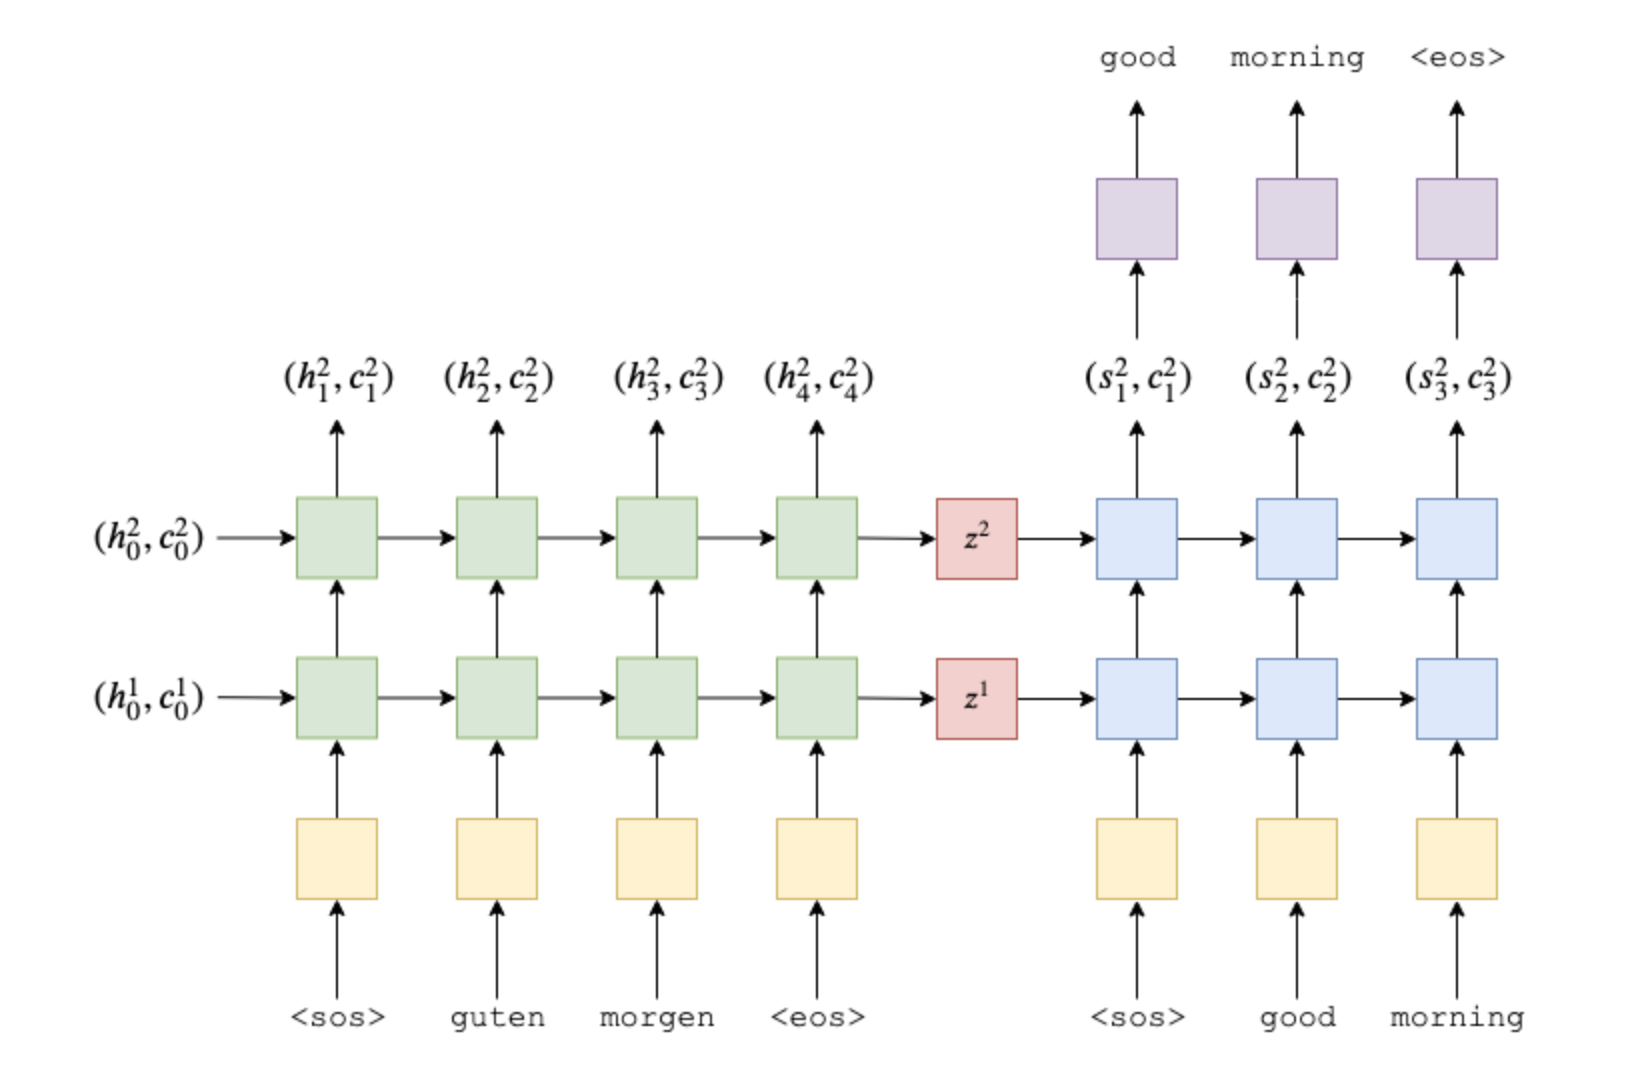

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

### Embedding and Encoder Steps:
1. Pass the input German sentence (in this example "guten morgen") through an embedding layer (the yellow squares).  The embedding layer creates a lookup hash table that maps these input strings into dense vectors of real numbers that a neural network can use (neural networks need numbers not strings!)
2. Incrementally pass the embedding of the current word $e(w_t)$ and the previous hidden state $h_{t-1}$ into the encoder RNN (the green squares). Note that here $W = {w_1,w_2,w_3,...,w_t}$ with $w_1 = <sos>, w_2= guten,...$ And $h_t = encoderRNN(h_{t-1},e(w_t))$ where we initially have $h_0$ be a zero vector.  Also the final $h_t$ value after all of the words have been passed in becomes the z variable below! Note that we could use any type of RNN for the green squares but for this paper they used a LSTM (instead of maybe a GRU or other type of RNN)

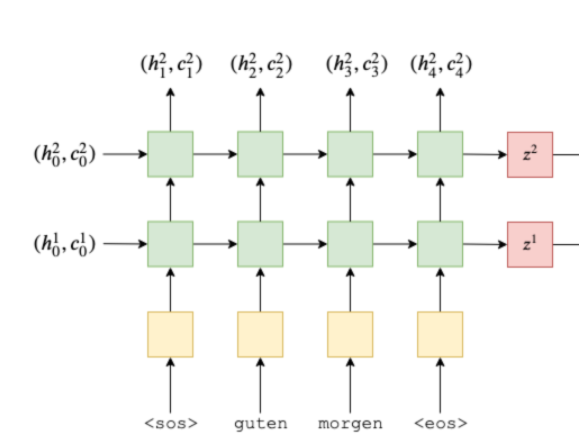

### Encoder LSTM Implementation: inheriting from pytorch's nn.Module (since it can be thought of as just a special type of NN) so that many of the neural network methods don't have to be reimplemented

In [11]:
##BY PASSING IN THE nn.Module we are saying this is a new type that inherits from the nn.Module model.  
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()          #This is where we say this Encoder model will inherit the methods of nn.Module
        
        self.hid_dim = hid_dim       #Setting up the structure of this RNN (hidden layer dimensions and number of layers)
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim) #Setting up the embedding layer that creates a lookup table that changes words into dense vectors of real numbers!
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) #Setting up the parameters of this RNN encoder to be LSTM and creating structure!
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)

        return hidden, cell

### Second Embedding Layer and Decoder Steps
3. Incrementally pass the previously predicted english word into the second embedding layer (we always start with sos, but after this point it is whatever our model predicted previously).  We learned that occasionally using a ground truth value called "teacher forcing" during training helps to quickly train the RNN model.  This would mean that there is a probability we use the previously correct english word for input into the encoder even if our model wasn't able to predict it correctly
4. This next step is the decoder RNN (blue squares).  Once again we use a LSTM structure for this RNN but we could try out a GRU architecture to test how it does! $s_t = decoderRNN(s_{t-1},e(w_t))$.  In this formula $e(w_t)$ is the current embedding of the previously predicted english word into a dense vector of values.  Then $s_t$ is the hidden state vector.  Thus initially $s_0$ is the last hidden state from step 2 ($h_t = z = s_0$)
5. This next step is a linear layer (purple squares).  It takes the current output of the neural network which is the current hidden state vector $s_t$ and it then creates a probability distribution across all of the words in the target language.  Then it chooses the word with the highest probability in the target language to be the word the model predicts at this time step!

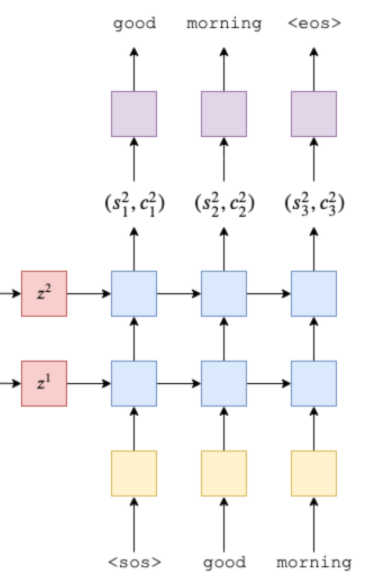

### Decoder LSTM Implementation:

In [32]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()  #This makes sure that this decoder is inheriting from pytorch's nn.Module so we don't have to reimplement many of the functions
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) #Making this RNN an LSTM type and setting other hyperparameters!
        self.fc_out = nn.Linear(hid_dim, output_dim) #Setting up the linear layer (purple squares) that leads to the english word predictions of the model
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        print(f"input was : {input}")
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))    
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0)) #THIS IS WHERE WE WOULD BE ABLE TO PRINT OUT THE PREDICTIONS OF OUR MODEL WE BELIEVE
        print(f"prediction is:{prediction}")
    
        return prediction, hidden, cell

### Full Sequence to Sequence Model Implementation.  Which combines the previously created encoder and decoder classes for the overall architecture

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder #This is where we instantiate the previously created encoder/decoder classes that get used as working pieces in this model
        self.decoder = decoder
        self.device = device #This just changes whether we are on CPU or GPU
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
  
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device) 

        #Final hidden state of encoder used as Z which is initial hidden state for decoder!!!
        hidden, cell = self.encoder(src)

        #First input for decoder is always <sos>!!
        input = trg[0,:]
        
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio  #This will either be a 1 or 0 if we are having the teacher force or not!
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Below we define the hyperparameters for this sequence to sequence model! We also initialize the weights of the model to be uniformly distributed at the beginning!

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08) #Uniformly distributing the initial weights of every parameter in our neural network model
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [15]:
def myTotParams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #THIS WILL COUNT UP EVERY TRAINABLE PARAMETER IN ANY GIVEN MODEL!!

print(f'The model has {myTotParams(model):,} trainable parameters')

The model has 13,899,013 trainable parameters


### Setting the optimizer to adam and setting the criteria to CrossEntropyLoss

In [16]:
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Below we define the training function which takes in the model to be trained, an iterator, the optimizer to be used, the loss criteria and clip

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
  
        optimizer.zero_grad()   
        output = model(src, trg)
        output_dim = output.shape[-1]  
        output = output[1:].view(-1, output_dim)
        
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            #print(f"The output of the model is: {output}")
            top1 = output.argmax(1)
            #print(f"The top word predicted is: {top1}")
            trg = trg[1:].view(-1)
            #print(f"The target of the model was: {trg}")
             

            loss = criterion(output, trg) #GETTING CURRENT CROSS ENTROPY LOSS FOR GIVEN OUTPUT AND TARGET
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Below is the cell where we finally train our model and define things like the number of epochs to train for.  Note that PPL stands for perplexity which is a quantity directly cumputable from negative log-likelihood!

In [20]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 14s
	Train Loss: 5.055 | Train PPL: 156.882
	 Val. Loss: 5.036 |  Val. PPL: 153.794
Epoch: 02 | Time: 1m 12s
	Train Loss: 4.492 | Train PPL:  89.326
	 Val. Loss: 4.844 |  Val. PPL: 126.934
Epoch: 03 | Time: 1m 12s
	Train Loss: 4.202 | Train PPL:  66.823
	 Val. Loss: 4.632 |  Val. PPL: 102.687
Epoch: 04 | Time: 1m 12s
	Train Loss: 3.974 | Train PPL:  53.202
	 Val. Loss: 4.537 |  Val. PPL:  93.453
Epoch: 05 | Time: 1m 13s
	Train Loss: 3.811 | Train PPL:  45.218
	 Val. Loss: 4.357 |  Val. PPL:  77.995
Epoch: 06 | Time: 1m 13s
	Train Loss: 3.661 | Train PPL:  38.909
	 Val. Loss: 4.299 |  Val. PPL:  73.618
Epoch: 07 | Time: 1m 14s
	Train Loss: 3.513 | Train PPL:  33.538
	 Val. Loss: 4.181 |  Val. PPL:  65.441
Epoch: 08 | Time: 1m 14s
	Train Loss: 3.379 | Train PPL:  29.347
	 Val. Loss: 4.023 |  Val. PPL:  55.857
Epoch: 09 | Time: 1m 13s
	Train Loss: 3.247 | Train PPL:  25.724
	 Val. Loss: 3.990 |  Val. PPL:  54.063
Epoch: 10 | Time: 1m 13s
	Train Loss: 3.112 | Train PPL

In [21]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.943 | Test PPL:  51.578 |


## Part 3: Testing Our German to English Translator Model.  We would like to be able to update some things in our model in the future in order to easily create predictions using our trained model for any german string that we want to input.  Right now we think that this would entail either printing out the squeezed vector in the decode function, or implementing an additional predict method in the overall sequence to sequence class.  Couldn't quite figure it out for the time being (we were trying to run a single epoch with the print statements uncommented that we believe would show the input and prediction for the model but didn't quite get it for now)


In [36]:
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 13s
	Train Loss: 2.955 | Train PPL:  19.209
	 Val. Loss: 3.879 |  Val. PPL:  48.372
